In [1]:
import os
import imageio
import numpy as np
import json
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
actual_path = '../ColabNotebooks/FullDataset/'
train_videos_path = 'train_sample_videos'
test_videos_path = 'test_videos'
saved_models_path = '../ColabNotebooks/'

In [6]:
def extractFrames(file_name, frame_step):
  video = imageio.get_reader(file_name, 'ffmpeg')
  return np.array([frame for i, frame in enumerate(video) if i % frame_step == 0])

In [7]:
def preProcessing(frames):
  # video_r_channel = np.zeros(frames.shape[0:3])
  # video_g_channel = np.zeros(frames.shape[0:3])
  # video_b_channel = np.zeros(frames.shape[0:3])

  # for i, frame in enumerate(frames):
  #   for j, row in enumerate(frame):
  #     for k, pixel in enumerate(row):
  #       video_r_channel[i][j][k] = pixel[0]
  #       video_g_channel[i][j][k] = pixel[1]
  #       video_b_channel[i][j][k] = pixel[2]

  video_r_channel = frames[:, :, :, 0]
  video_g_channel = frames[:, :, :, 1]
  video_b_channel = frames[:, :, :, 2]

  return video_r_channel, video_g_channel, video_b_channel

In [8]:
# Returns correlation value
def superimpose(frame: np.ndarray, kernel: np.ndarray):
  n = kernel.shape[0]
  mid = n // 2

  superimposed_matrix = frame * kernel
  return sum(superimposed_matrix.flatten()) - superimposed_matrix[mid][mid]

In [9]:
def isValid(index, length, skip):
  return index >= skip and index < length - skip

In [10]:
# Channel is a 3D matrix: (number of frames, height, width)
# each element represents the pixel value of the given channel

def convolve(channel, kernel):
  n = len(kernel) # Kernel is of dimension n x n
  skip = n // 2 # No. of rows and cols to be skipped

  num_frames, height, width = channel.shape

  # res_frames = np.zeros((len(frames), height - 2 * skip, width - 2 * skip))
  res_channel = np.zeros(channel.shape)

  for i, frame in enumerate(channel):
    print(f'Frame: {i}')

    for j, row in enumerate(frame):
      if not isValid(j, height, skip):
        continue

      for k, pixel in enumerate(row):
        if not isValid(k, width, skip):
          continue

        subframe = frame[j - skip: j + skip + 1, k - skip: k + skip + 1]

        res_channel[i][j][k] = superimpose(subframe, kernel)

  return res_channel[:, skip:-skip, skip:-skip]

In [11]:
def saveAsVideo(frames, file_name, fps):
  frames = frames.astype('uint8')
  writer = imageio.get_writer(file_name, fps=fps, macro_block_size=None)
  for frame in frames:
    writer.append_data(frame)

In [36]:
def get_training_data(frame, kernel_size):
  skip = kernel_size // 2 # No. of rows and cols to be skipped

  convolved_frame = frame[skip:-skip, skip:-skip]
  # print(f'CF: {convolved_frame.shape}')
  height, width = convolved_frame.shape
  # print(height, width)

  X_data = np.zeros((height * width, kernel_size ** 2))
  Y_data = np.zeros((height* width, 1))

  for i, row in enumerate(convolved_frame):
    for j, pixel in enumerate(row):
      if i * width + j >= height * width:
        print(i , j)
        continue
      subframe = frame[i: i + kernel_size, j: j + kernel_size]

      X_data[i * width + j] = subframe.flatten()
      Y_data[i * width + j] = subframe[skip][skip]

  return  np.delete(X_data, skip * kernel_size + skip, 1), Y_data.ravel()

# def get_training_data(frame, kernel_size):
#   skip = kernel_size // 2 # No. of rows and cols to be skipped

#   height, width = frame.shape

#   X = []
#   Y = []

#   for i, row in enumerate(frame):
#     if not isValid(i, height, skip):
#       continue

#     for j, pixel in enumerate(row):
#       if not isValid(j, width, skip):
#         continue

#       subframe = frame[i - skip: i + skip + 1, j - skip: j + skip + 1]

#       X.append(np.delete(subframe.flatten(), skip * kernel_size + skip))
#       Y.append(subframe[skip, skip])

#   return X, Y

# Saving channel frames

In [13]:
def saveChannels():
  json_file = open(actual_path + train_videos_path + '/metadata.json')
  data = json.load(json_file)

  for file in data:
    if file == 'metadata.json':
      continue

    file_index = files.index(file) + 1
    get_feature_vectors(train_videos_path,file_index,3)

# Extracting Feature Vectors

In [14]:
#get the RGB-channels
def get_channels(path,file_index):
  path = actual_path + path
  files = os.listdir(path)

  frames = np.array(extractFrames(os.path.join(path, files[file_index]), 30))
  return preProcessing(frames)

In [15]:
#Predicts the kernel values using stochastic gradient descent
def predict_kernel(channel_frame,kernel_size):
  
  actual = channel_frame[1:-1, 1:-1]
  X, Y = get_training_data(channel_frame, kernel_size)

  l_model = make_pipeline(StandardScaler(), SGDRegressor())
  l_model.fit(X, Y)

  # print("Model score - ",l_model.score(X, Y))

  pred_frame = l_model.predict(X).reshape(actual.shape)
  err_frame = abs(pred_frame - actual).astype('uint8')

  predicted_kernel = l_model['sgdregressor'].coef_
  predicted_kernel = np.insert(predicted_kernel,4,1/(kernel_size ** 2))
  
  # predicted_kernel = np.reshape(predicted_kernel,(kernel_size,kernel_size))

  return predicted_kernel

In [16]:
# get the feature vectors
def get_feature_vectors(path,file_index,kernel_size):
  frame_ind = 1
  video_r_channel,video_g_channel,video_b_channel = get_channels(path,file_index)

  predicted_r_kernel = predict_kernel(video_r_channel[frame_ind],kernel_size)
  predicted_g_kernel = predict_kernel(video_g_channel[frame_ind],kernel_size)
  predicted_b_kernel = predict_kernel(video_b_channel[frame_ind],kernel_size)

  return [*predicted_r_kernel,*predicted_g_kernel,*predicted_b_kernel]

## SAMPLE TESTING

In [17]:
feature_vector1 = get_feature_vectors(train_videos_path,5,3)
feature_vector1

CF: (1078, 1918)
1078 1918
CF: (1078, 1918)
1078 1918
CF: (1078, 1918)
1078 1918


[-9.222158640645132,
 24.654032203328033,
 -13.27269695229413,
 42.04941610448534,
 0.1111111111111111,
 42.02170634509968,
 -13.27532384060387,
 24.667267524979287,
 -9.252478448462298,
 -8.923481729562099,
 24.191746736091286,
 -13.028656632927984,
 42.49776002039441,
 0.1111111111111111,
 42.4854788573395,
 -13.031602177962725,
 24.211177692431814,
 -8.931653203365107,
 -11.013241243115399,
 26.259865146406284,
 -14.2520114841005,
 35.38988534032329,
 0.1111111111111111,
 35.366140881167496,
 -14.240172483740842,
 26.282342950591786,
 -11.029332865909344]

In [ ]:
feature_vector1 = get_feature_vectors(train_videos_path,5,3)
feature_vector1

(10, 1080, 1920)


[-13.32647291626992,
 29.111178489509502,
 -15.287690187404996,
 34.75518277864072,
 0.1111111111111111,
 34.721453419395175,
 -15.314972699415522,
 29.052570175240263,
 -13.35123183434567,
 -13.802600644599854,
 30.500209519710065,
 -15.911499117576392,
 37.1245761055409,
 0.1111111111111111,
 37.105118294803255,
 -15.942640115142526,
 30.46600386600649,
 -13.796454578204251,
 -13.198368970383543,
 28.630585161654537,
 -15.100750134356812,
 32.692519980881954,
 0.1111111111111111,
 32.64497949537944,
 -15.105707561022427,
 28.580474167091364,
 -13.234732114478774]

In [ ]:
feature_vector2 = get_feature_vectors(train_videos_path,1,3)
feature_vector2

Model score -  0.9998157097426843
Model score -  0.9998517182724885
Model score -  0.9997704273626759


[-12.145826184406491,
 27.497707982791162,
 -13.784565864478262,
 29.702801447803328,
 0.1111111111111111,
 29.687182045569347,
 -13.77245782698085,
 27.473350115212906,
 -12.140573955756967,
 -12.848906863115094,
 30.03569317577755,
 -14.652569181553693,
 32.931704641336744,
 0.1111111111111111,
 32.94900449928754,
 -14.663798463257598,
 30.06314286532298,
 -12.805754919651694,
 -11.818217925885053,
 26.13768584659429,
 -13.205785805700856,
 27.598733199948374,
 0.1111111111111111,
 27.61414423529689,
 -13.197497911980477,
 26.166554665743384,
 -11.79372998327796]

In [ ]:
feature_vector3 = get_feature_vectors(train_videos_path,27,3)
feature_vector3

Model score -  0.9998186478292372
Model score -  0.9997032644310994
Model score -  0.9991434066308886


[-3.984563916362979,
 10.067398215081129,
 -4.061895104895461,
 10.688487495337473,
 0.1111111111111111,
 10.694178594268964,
 -4.087853777522906,
 10.046206034784985,
 -4.003112730006857,
 -3.3091686977491923,
 7.822159317330326,
 -3.342597136751751,
 8.324731796050111,
 0.1111111111111111,
 8.329801246288131,
 -3.3807504773756296,
 7.808697709605882,
 -3.3253901970333173,
 -2.497306098680359,
 5.270075531225996,
 -2.5106297947039766,
 5.37662558214536,
 0.1111111111111111,
 5.363432753005524,
 -2.4802704167801624,
 5.299164838342867,
 -2.4887375766082966]

In [ ]:
files = os.listdir(actual_path + train_videos_path)
index = 1 + files.index("atvmxvwyns.mp4")
feature_vector4 = get_feature_vectors(train_videos_path,index,3)
feature_vector4

Model score -  0.9988351375391714
Model score -  0.9988929783061039
Model score -  0.9989940262119779


[-13.727753838656627,
 27.067139424061466,
 -14.044349533170054,
 33.64682218313105,
 0.1111111111111111,
 33.624975243426796,
 -13.943372629736063,
 27.154293251709387,
 -13.654750025945592,
 -13.880758658118337,
 27.41083572819165,
 -14.193082958559526,
 34.36040976185072,
 0.1111111111111111,
 34.394230182760865,
 -14.160450269483544,
 27.467544980640138,
 -13.817818814612528,
 -15.938395644172394,
 31.70396313934258,
 -16.295698757938098,
 37.0821538921988,
 0.1111111111111111,
 37.08289026678596,
 -16.25981592120442,
 31.750454563949187,
 -15.934430879537125]

In [ ]:
files = os.listdir(actual_path + train_videos_path)
index = files.index("bbhtdfuqxq.mp4")
feature_vector5 = get_feature_vectors(train_videos_path,index,3)
feature_vector5

Model score -  0.9998620611126657
Model score -  0.9998062002947095
Model score -  0.9997750808519683


[-13.402054751362854,
 26.706620795063007,
 -12.61549508851213,
 29.677908136954862,
 0.1111111111111111,
 29.67376513007467,
 -12.598098269098944,
 26.680335735493493,
 -13.388880309744975,
 -11.437098247902547,
 22.53079555981313,
 -10.836285550720284,
 24.730868936910422,
 0.1111111111111111,
 24.757731184031602,
 -10.81123437056843,
 22.481334257308713,
 -11.423243573821964,
 -10.918030709643213,
 21.441798065968715,
 -10.36606003078773,
 23.267121015141726,
 0.1111111111111111,
 23.232384922333296,
 -10.34046704604671,
 21.42271814971987,
 -10.92079291925445]

In [ ]:
feature_vectors = [feature_vector1,feature_vector2,feature_vector3,feature_vector4,feature_vector5]
labels = [1,1,0,0,1]

## Pickle Functions

In [5]:
def write_pickle(path, data):
  with open(path, 'wb') as fp:
    pickle.dump(data, fp)

In [6]:
def read_pickle(path):
  with open(path, 'rb') as fp:
    return pickle.load(fp)

**Writing the feature vectors and labels to binary file**

# Train Data for Classifier

In [20]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

In [21]:
def initialize_feature_vectors():
  try:
    count = read_pickle(saved_models_path+'eq2_feature_count')
    feature_vectors = read_pickle(saved_models_path+'eq2_feature_vectors')
    labels = read_pickle(saved_models_path+'eq2_labels')
  except FileNotFoundError:
    return 0, [], []

  if count == 0:
    return 0, [], []
  
  return count, feature_vectors[:count+1], labels[:count+1]

In [22]:
files = os.listdir(actual_path + train_videos_path)
len(files)

401

In [23]:
cls = ['REAL','FAKE']

json_file = open(actual_path + train_videos_path + '/metadata.json')
data = json.load(json_file)

In [38]:
real = 0
fake = 0

checkpoint, feature_vectors, labels = initialize_feature_vectors()
count = 0

for file in data:
  if file == 'metadata.json':
    continue

  curr_label = data[file]['label']
  file_index = files.index(file) + 1

  if count < checkpoint:
    print(count, checkpoint)
    if labels[count] == 1:
      fake += 1
    elif labels[count] == 0:
      real += 1

    count += 1
    continue

  if curr_label == 'FAKE' and fake <= 70:
    feature_vectors.append(get_feature_vectors(train_videos_path,file_index,3))
    labels.append(cls.index(curr_label))
    fake += 1
    print(file,curr_label, count, fake)
  
  if curr_label == 'REAL' and real <= 70:
    feature_vectors.append(get_feature_vectors(train_videos_path,file_index,3))
    labels.append(cls.index(curr_label))
    real += 1
    print(file,curr_label, count, real)


  count += 1
  if count != 0:
    write_pickle(saved_models_path+'eq2_feature_vectors', feature_vectors)
    write_pickle(saved_models_path+'eq2_labels', labels)
    write_pickle(saved_models_path+'eq2_feature_count', count)
    write_pickle(saved_models_path+'eq2_file_index', file_index)
  
  # if count >= 140:
  if fake > 70 and real > 70:
    break

aagfhgtpmv.mp4 FAKE 0 1
aapnvogymq.mp4 FAKE 1 2
abarnvbtwb.mp4 REAL 2 1
abofeumbvv.mp4 FAKE 3 3
abqwwspghj.mp4 FAKE 4 4
acifjvzvpm.mp4 FAKE 5 5
acqfdwsrhi.mp4 FAKE 6 6
acxnxvbsxk.mp4 FAKE 7 7
acxwigylke.mp4 FAKE 8 8
aczrgyricp.mp4 FAKE 9 9
adhsbajydo.mp4 FAKE 10 10
adohikbdaz.mp4 FAKE 11 11
adylbeequz.mp4 FAKE 12 12
aelfnikyqj.mp4 REAL 13 2
aelzhcnwgf.mp4 FAKE 14 13
aettqgevhz.mp4 FAKE 15 14
aevrfsexku.mp4 FAKE 16 15
afoovlsmtx.mp4 REAL 17 3
agdkmztvby.mp4 FAKE 18 16
agqphdxmwt.mp4 FAKE 19 17
agrmhtjdlk.mp4 REAL 20 4
ahbweevwpv.mp4 FAKE 21 18
ahdbuwqxit.mp4 FAKE 22 19
ahfazfbntc.mp4 FAKE 23 20
ahqqqilsxt.mp4 REAL 24 5
aipfdnwpoo.mp4 FAKE 25 21
ajqslcypsw.mp4 REAL 26 6
ajwpjhrbcv.mp4 FAKE 27 22
aklqzsddfl.mp4 FAKE 28 23
aknbdpmgua.mp4 FAKE 29 24
aknmpoonls.mp4 FAKE 30 25
akvmwkdyuv.mp4 FAKE 31 26
akxoopqjqz.mp4 FAKE 32 27
akzbnazxtz.mp4 FAKE 33 28
aladcziidp.mp4 FAKE 34 29
alaijyygdv.mp4 FAKE 35 30
alninxcyhg.mp4 FAKE 36 31
altziddtxi.mp4 FAKE 37 32
alvgwypubw.mp4 FAKE 38 33
amaivqofda.

In [ ]:
labels

In [ ]:
feature_vectors

In [ ]:
print(real, fake)

50 50


## Extras

In [ ]:
# with open(saved_models_path+'feature_vectors', 'wb') as fp:
#   pickle.dump(feature_vectors, fp)

write_pickle(saved_models_path+'new_feature_vectors', feature_vectors)

In [ ]:
# with open(saved_models_path+'labels', 'wb') as fp:
#   pickle.dump(labels, fp)

write_pickle(saved_models_path+'new_labels', labels)

**Reading feature vectors and labels from binary file**

In [ ]:
# with open(saved_models_path+'feature_vectors', 'rb') as fp:
#   # global feature_vectors
#   feature_vectors  = pickle.load(fp)

In [ ]:
# with open(saved_models_path+'labels', 'rb') as fp:
#   # global labels
#   labels  = pickle.load(fp)

In [ ]:
tmpFeatures = read_pickle(saved_models_path+'new_feature_vectors')
tmpFeatures

In [ ]:
tmpLabels = read_pickle(saved_models_path+'new_labels')
tmpLabels

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

# Classification

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

## Choosing a dataset

**Sample Dataset**

In [ ]:
feature_vectors = read_pickle(saved_models_path+'new_feature_vectors')
labels = read_pickle(saved_models_path+'new_labels')

**50-50 Dataset**

In [10]:
feature_vectors_1 = read_pickle(saved_models_path+'eq_feature_vectors')
labels_1 = read_pickle(saved_models_path+'eq_labels')

feature_vectors_2 = read_pickle(saved_models_path+'eq2_feature_vectors')
labels_2 = read_pickle(saved_models_path+'eq2_labels')

In [11]:
labels_1.pop(-1)
print(len(labels_1))
feature_vectors_1.pop(0)

labels_2.pop(-1)
print(len(labels_2))
feature_vectors_2.pop(0)



99
141


[-8.408487541310954,
 18.750059336531177,
 -6.903544076496444,
 18.803949249029554,
 0.1111111111111111,
 18.811014412356673,
 -6.929191045712376,
 18.73469824473348,
 -8.413387269456031,
 -8.292691183694306,
 18.786198412912505,
 -6.7068301195822,
 18.849818732169673,
 0.1111111111111111,
 18.862307435417165,
 -6.718173766186683,
 18.792665714830708,
 -8.298533645887062,
 -9.15892942841807,
 20.50518976813803,
 -7.6415730067112415,
 20.406467649377138,
 0.1111111111111111,
 20.40379524884779,
 -7.667683449223067,
 20.480566916748284,
 -9.18629049774607]

In [12]:
feature_vectors = np.append(np.array(feature_vectors_1), np.array(feature_vectors_2), 0)
labels = np.append(np.array(labels_1), np.array(labels_2), 0)

print(feature_vectors.shape, labels.shape)

(240, 27) (240,)


## Reducing dimensions using LDA

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [18]:
lda = LDA()
lda.fit(feature_vectors, labels)

transformed_features = lda.transform(feature_vectors)

## Reducing dimensions using PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=20)
pca.fit(feature_vectors, labels)

pca_features = pca.transform(feature_vectors)

## Test Train Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2)

In [ ]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(transformed_features, labels, test_size=0.2, random_state=24)

In [ ]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(pca_features, labels, test_size=0.2)

## SVM classifier

In [65]:
from sklearn import svm

### Direct Dataset

In [66]:
clf = svm.SVC(kernel='linear', degree=3)

In [67]:
clf = clf.fit(X_train, y_train)

In [68]:
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
conf = confusion_matrix(y_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.6041666666666666
Confusion Matrix:
[[14  8]
 [11 15]]


### LDA Dataset

In [69]:
clf = svm.SVC(kernel='rbf', degree=3)

In [70]:
# Fit data
clf = clf.fit(Xt_train, yt_train)

In [71]:
pred = clf.predict(Xt_test)
acc = accuracy_score(yt_test, pred)
conf = confusion_matrix(yt_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.6041666666666666
Confusion Matrix:
[[18  8]
 [11 11]]


### PCA Dataset

In [ ]:
clf = svm.SVC(kernel='linear', degree=3)
clf = clf.fit(Xp_train, yp_train)
pred = clf.predict(Xp_test)

In [ ]:
acc = accuracy_score(yp_test, pred)
conf = confusion_matrix(yp_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.5
Confusion Matrix:
[[5 3]
 [7 5]]


## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

### Training & Classification (Normal Dataset)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,60,), max_iter=1000, random_state=45)
mlp = mlp.fit(feature_vectors, labels)

In [ ]:
pred = mlp.predict(feature_vectors)
acc = accuracy_score(labels, pred)
conf = confusion_matrix(labels, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.7070707070707071
Confusion Matrix:
[[34 16]
 [13 36]]


### Training & Classification (Transformed Dataset)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,60,), max_iter=800, random_state=8)
mlp = mlp.fit(transformed_features, labels)

In [ ]:
pred = mlp.predict(transformed_features)
acc = accuracy_score(labels, pred)
conf = confusion_matrix(labels, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.6565656565656566
Confusion Matrix:
[[23 27]
 [ 7 42]]


### PCA Dataset

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,30,), max_iter=2000, random_state=5)
mlp = mlp.fit(Xp_train, yp_train)
pred = mlp.predict(Xp_test)

In [ ]:
acc = accuracy_score(yp_test, pred)
conf = confusion_matrix(yp_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.15
Confusion Matrix:
[[ 1  7]
 [10  2]]


## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Training & Classification (Normal Dataset)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn = knn.fit(X_train, y_train)

In [ ]:
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred)
conf = confusion_matrix(y_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.5
Confusion Matrix:
[[12  6]
 [ 9  3]]


### Training & Classification (Transformed Dataset)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn = knn.fit(Xt_train, yt_train)

In [ ]:
pred = knn.predict(Xt_test)
acc = accuracy_score(yt_test, pred)
conf = confusion_matrix(yt_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.8
Confusion Matrix:
[[7 4]
 [0 9]]


### PCA Dataset

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn = knn.fit(Xp_train, yp_train)
pred = knn.predict(Xp_test)

In [ ]:
acc = accuracy_score(yp_test, pred)
conf = confusion_matrix(yp_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.6
Confusion Matrix:
[[ 1  7]
 [ 1 11]]


## Naive-Bayes Classification

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Actual Dataset

In [ ]:
nb = GaussianNB()
nb = nb.fit(X_train, y_train)

In [ ]:
pred = nb.predict(X_test)
acc = accuracy_score(y_test, pred)
conf = confusion_matrix(y_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.43333333333333335
Confusion Matrix:
[[ 5 10]
 [ 7  8]]


### Transformed Dataset

In [ ]:
nb = GaussianNB()
nb = nb.fit(Xt_train, yt_train)

In [ ]:
pred = nb.predict(Xt_test)
acc = accuracy_score(yt_test, pred)
conf = confusion_matrix(yt_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.6
Confusion Matrix:
[[7 4]
 [4 5]]


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

### Actual Dataset

In [ ]:
lr = LogisticRegression(max_iter=2000, solver='newton-cg')
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

In [ ]:
pred = lr.predict(X_test)
acc = accuracy_score(y_test, pred)
conf = confusion_matrix(y_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.4666666666666667
Confusion Matrix:
[[ 5 10]
 [ 6  9]]


### LDA Dataset

In [ ]:
lr = LogisticRegression(max_iter=2000, solver='saga')
lr.fit(Xt_train, yt_train)
pred = lr.predict(Xt_test)

In [ ]:
pred = lr.predict(Xt_test)
acc = accuracy_score(yt_test, pred)
conf = confusion_matrix(yt_test, pred)

print(f'Accuracy: {acc}')
print("Confusion Matrix:")
print(conf)

Accuracy: 0.65
Confusion Matrix:
[[7 4]
 [3 6]]


## Decision Tree

In [16]:
from sklearn import tree

In [17]:
tr = tree.DecisionTreeRegressor(random_state = 8)
tr.fit(X_train, y_train)
pred = tr.predict(feature_vectors)

In [18]:
acc = accuracy_score(labels, pred)
conf = confusion_matrix(labels, pred)

print(f'Accuracy score: {acc}')
print(f'Precision score: {precision_score(labels, pred)}')
print(f'Recall score: {recall_score(labels, pred)}')
print("Confusion Matrix:")
print(conf)

Accuracy score: 0.9416666666666667
Precision score: 0.9495798319327731
Recall score: 0.9338842975206612
Confusion Matrix:
[[113   6]
 [  8 113]]


## Pycaret Classification

In [ ]:
! pip install pycaret==1.0.0

In [ ]:
!pip install Jinja2==2.11.1

In [19]:
import pandas as pd
from pycaret.utils import version
from pycaret.classification import *

In [20]:
version()

1.0.0


In [21]:
np.array(feature_vectors).shape

(240, 27)

In [ ]:
[str(x) for x in range(27)] + ['target']

In [23]:
train_d = pd.DataFrame(data= np.c_[feature_vectors, labels], columns=([str(x) for x in range(27)] + ['target']))
train_d.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,target
0,-14.158693,29.234642,-15.176960,36.080448,0.111111,36.063438,-15.184316,29.228119,-14.174237,-14.517482,...,-15.710478,32.059733,-16.467948,34.315701,0.111111,34.288119,-16.423563,32.075424,-15.691189,1.0
1,-2.157829,9.136140,-2.664944,8.961231,0.111111,8.965438,-2.652102,9.135669,-2.155781,-1.848209,...,-2.405960,5.818325,-2.586354,5.705741,0.111111,5.696910,-2.590481,5.811939,-2.401716,1.0
2,-16.897737,29.377561,-14.954950,33.399331,0.111111,33.408948,-14.971712,29.384454,-16.848388,-12.264958,...,-9.203782,15.791291,-8.257408,17.780428,0.111111,17.748604,-8.274190,15.767583,-9.238575,0.0
3,-13.361316,29.089879,-15.310807,34.759646,0.111111,34.722953,-15.293355,29.084548,-13.310722,-13.836003,...,-13.204518,28.620108,-15.098019,32.680571,0.111111,32.661593,-15.113669,28.595902,-13.212808,1.0
4,-2.010220,9.094708,-2.728190,8.926709,0.111111,8.928487,-2.727189,9.076611,-1.997040,-1.697189,...,-2.314068,5.767524,-2.619342,5.666700,0.111111,5.662489,-2.616914,5.763542,-2.301439,1.0


In [ ]:
s = setup(train_d, target='target')

# Visualizing Transformed Dataset

## LDA

In [ ]:
import seaborn as sns
import matplotlib as plt

sns.set(rc={'figure.figsize':(8,5)})

In [ ]:
tfx = np.array(Xt_test)
tfl = np.array(yt_test).reshape(-1, 1)

Text(0, 0.5, 'LDA1')

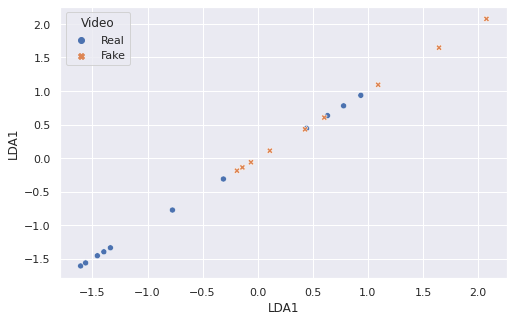

In [ ]:
ax = sns.scatterplot(x=tfx.T[0], 
                     y=tfx.T[0], 
                     hue=["Real" if x == 0 else "Fake" for x in tfl.T[0]], 
                     style=["Real" if x == 0 else "Fake" for x in tfl.T[0]])


ax.legend(title="Video")
ax.set_xlabel("LDA1")
ax.set_ylabel("LDA1")
# plt.show(ax)

## PCA

In [ ]:
tfx = np.array(Xp_test)
tfl = np.array(yp_test).reshape(-1, 1)

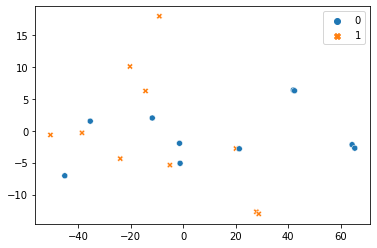

In [ ]:
sns.scatterplot(x=tfx.T[0], y=tfx.T[1], hue=tfl.T[0], style=tfl.T[0], sizes=[5, 50])

## 3D PCA

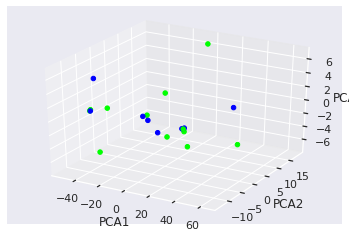

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

tfx = np.array(Xp_test).T
tfl = np.array(yp_test).reshape(-1, 1)

x = tfx[0]
y = tfx[1]
z = tfx[2]

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

ax.scatter(x, y, z, c=tfl.T[0], depthshade=False, cmap='brg')

plt.show()

# EXTRAS

In [ ]:
test_feature_vector2 = get_feature_vectors(test_videos_path,5,3)
test_feature_vector2

In [ ]:
predictions = clf.predict([test_feature_vector2])
predictions

array([0])

In [ ]:
tmpval = 5
write_pickle(saved_models_path+'tmp', tmpval)
tmpnewval = read_pickle(saved_models_path+'tmp')
print(tmpnewval)

5


## Predicting Kernel for R-channel

In [ ]:
actual_r = video_r_channel[0][1:-1, 1:-1]
actual_r

array([[163., 163., 163., ..., 158., 158., 158.],
       [163., 163., 163., ..., 158., 158., 158.],
       [163., 163., 163., ..., 159., 159., 159.],
       ...,
       [ 52.,  51.,  51., ..., 253., 253., 253.],
       [ 52.,  52.,  52., ..., 253., 253., 253.],
       [ 52.,  52.,  52., ..., 253., 253., 253.]])

In [ ]:
X, Y = get_training_data(video_r_channel[0], 3)

In [ ]:
l_model = make_pipeline(StandardScaler(), SGDRegressor())
l_model.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [ ]:
l_model.score(X, Y)

0.9998520096814505

In [ ]:
print(l_model['sgdregressor'].coef_)
print(l_model['sgdregressor'].intercept_)

[-7.58827771 18.75832649 -7.36847114 18.96410562 18.96762053 -7.37844164
 18.76627338 -7.57529125]
[115.89535602]


In [ ]:
pred_r_frame = l_model.predict(X).reshape(actual_r.shape)

In [ ]:
err_r_frame = abs(pred_r_frame - actual_r).astype('uint8')

In [ ]:
imageio.imwrite('org_gradient_descent_error_r.jpg', err_r_frame)

In [ ]:
sum(abs(actual_r.flatten() - l_model.predict(X))) / len(actual_r.flatten())

0.2566467224544769

In [ ]:
saveAsVideo(video_r_channel, 'video_r.mp4', 5)
saveAsVideo(video_g_channel, 'video_g.mp4', 5)
saveAsVideo(video_b_channel, 'video_b.mp4', 5)

In [ ]:
predicted_r_kernel = l_model['sgdregressor'].coef_
predicted_r_kernel = np.insert(predicted_r_kernel,4,l_model['sgdregressor'].intercept_)
predicted_r_kernel = np.reshape(predicted_r_kernel,(3,3))

predicted_r_kernel

array([[ -7.58827771,  18.75832649,  -7.36847114],
       [ 18.96410562, 115.89535602,  18.96762053],
       [ -7.37844164,  18.76627338,  -7.57529125]])

In [ ]:
predicted_r = convolve(np.array([video_r_channel[0]]), predicted_r_kernel).astype('uint8')
predicted_r

Frame: 0


array([[[255, 255, 255, ...,  28,  28,  28],
        [255, 255, 255, ...,  32,  32,  32],
        [255, 255, 255, ...,  69,  69,  69],
        ...,
        [ 34,  30,  33, ...,   3,   3,   3],
        [ 94,  52,  49, ...,   3,   3,   3],
        [ 87,  72,  75, ...,   3,   3,   3]]], dtype=uint8)

In [ ]:
imageio.imwrite('predicted_image_r.jpg', predicted_r[0])

In [ ]:
diff = abs(actual_r - predicted_r[0]).astype('uint8')
diff

array([[ 92,  92,  92, ..., 130, 130, 130],
       [ 92,  92,  92, ..., 126, 126, 126],
       [ 92,  92,  92, ...,  90,  90,  90],
       ...,
       [ 18,  21,  18, ..., 250, 250, 250],
       [ 42,   0,   3, ..., 250, 250, 250],
       [ 35,  20,  23, ..., 250, 250, 250]], dtype=uint8)

In [ ]:
(1 / len(diff.flatten())) * sum((diff ** 2).flatten())

105.09239099943701

In [ ]:
imageio.imwrite('error_image_r.jpg', diff)

# Test Run

In [ ]:
index = files.index("acqfdwsrhi.mp4")
feature_vector_fake = get_feature_vectors(train_videos_path,index,3)

In [ ]:
pred1 = tr.predict([feature_vector_fake]).astype("uint8")
print("FAKE" if pred1 == 1 else "REAL")

FAKE


In [ ]:
index = files.index("ccfoszqabv.mp4")
feature_vector_real = get_feature_vectors(train_videos_path,index,3)

In [ ]:
pred2 = tr.predict([feature_vector_real]).astype("uint8")
print("FAKE" if pred2 == 1 else "REAL")

REAL


In [ ]:
index = files.index("aagfhgtpmv.mp4")
feature_vector_test = get_feature_vectors(train_videos_path,index,3)

In [ ]:
pred_test = tr.predict([feature_vector_test]).astype("uint8")
print("FAKE" if pred_test == 1 else "REAL")

FAKE


In [ ]:
# adohikbdaz
index = files.index("adohikbdaz.mp4")
feature_vector_test = get_feature_vectors(train_videos_path,index,3)

In [ ]:
pred_test = tr.predict([feature_vector_test]).astype("uint8")
print("FAKE" if pred_test == 1 else "REAL")

FAKE


In [ ]:
# ahqqqilsxt
index = files.index("ahqqqilsxt.mp4")
feature_vector_test = get_feature_vectors(train_videos_path,index,3)

In [ ]:
pred_test = tr.predict([feature_vector_test]).astype("uint8")
print("FAKE" if pred_test == 1 else "REAL")

REAL


In [ ]:
write_pickle(saved_models_path + 'ahqqqilsxt',feature_vector_test)
write_pickle(saved_models_path + 'ccfoszqabv',feature_vector_real)
write_pickle(saved_models_path + 'acqfdwsrhi',feature_vector_fake)